This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

Update the John Holkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [64]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [65]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

The "data date" is 2020-05-31 00:00:00

ADF Statistic: -1.697985
p-value: 0.432151
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


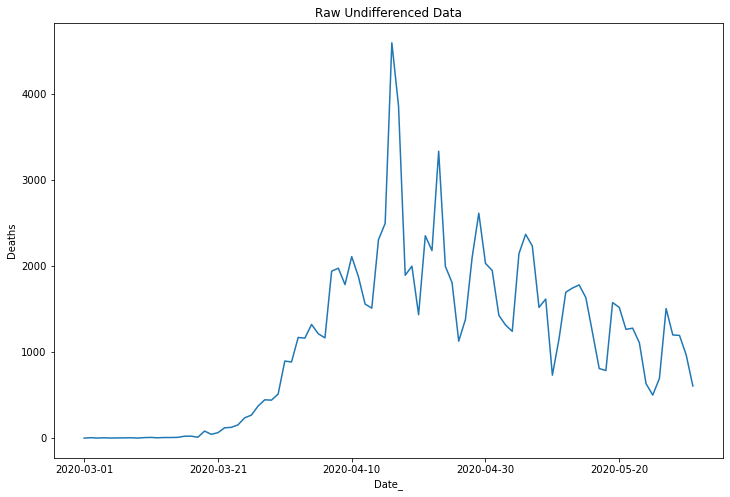

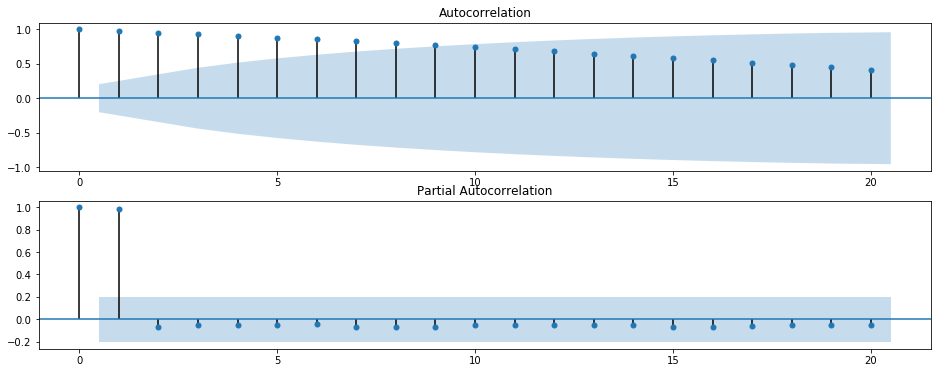

ARIMA(0, 0, 1) RMSE=38462.387
ARIMA(0, 1, 1) RMSE=1230.004
ARIMA(0, 2, 1) RMSE=669.752
ARIMA(0, 2, 2) RMSE=752.472
ARIMA(1, 0, 0) RMSE=1857.830
ARIMA(1, 1, 0) RMSE=647.728
ARIMA(1, 2, 0) RMSE=679.661
ARIMA(1, 2, 1) RMSE=698.825
ARIMA(2, 1, 0) RMSE=675.659
ARIMA(2, 2, 0) RMSE=810.732
Best ARIMA(1, 1, 0) RMSE=647.728
RMSE: 647.728
                 0
count    47.000000
mean     53.392278
std     652.502648
min   -1910.415504
25%    -306.625689
50%      14.097912
75%     281.321453
max    2117.744661


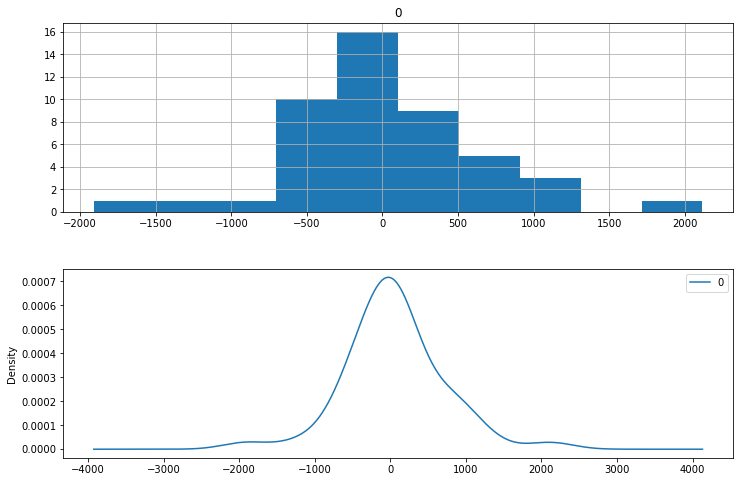


bias IS saved in arg_dict["bias"] for subsequent run is: 53.392277861697714 

RMSE: 645.524
                  0
count  4.700000e+01
mean  -2.322114e-13
std    6.525026e+02
min   -1.963808e+03
25%   -3.600180e+02
50%   -3.929437e+01
75%    2.279292e+02
max    2.064352e+03


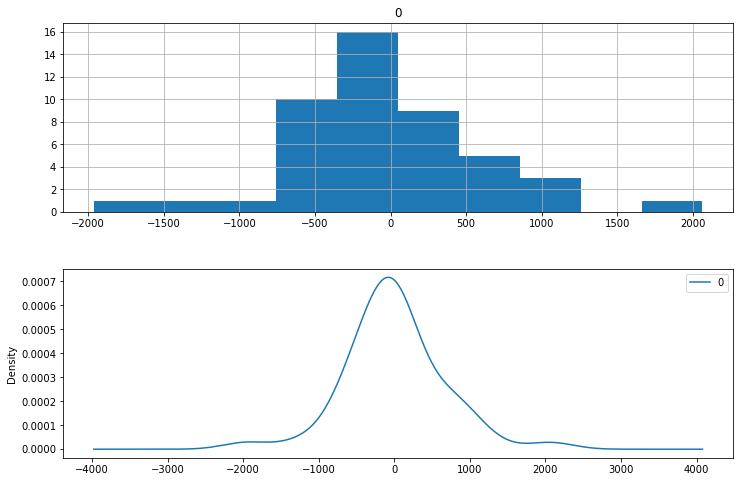


bias NOT saved in arg_dict["bias"] for subsequent run is: -2.3221141321861996e-13 



In [66]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 104,736


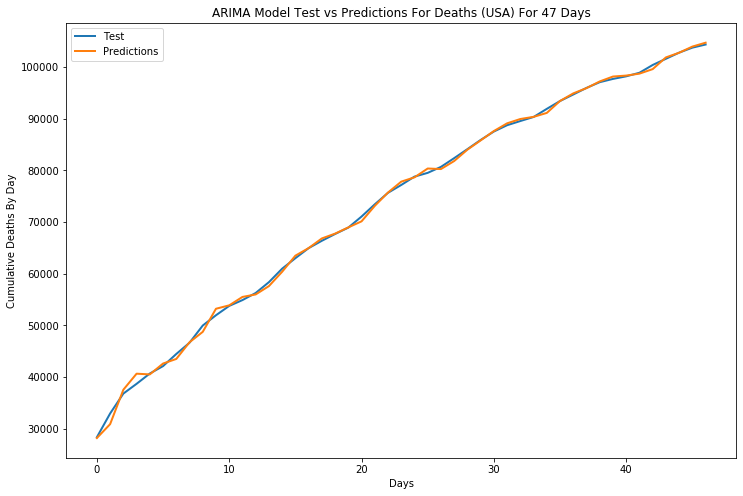

In [67]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

The USA prediction is for 322,995 cumulative Deaths to occur by 2020-12-31 00:00:00


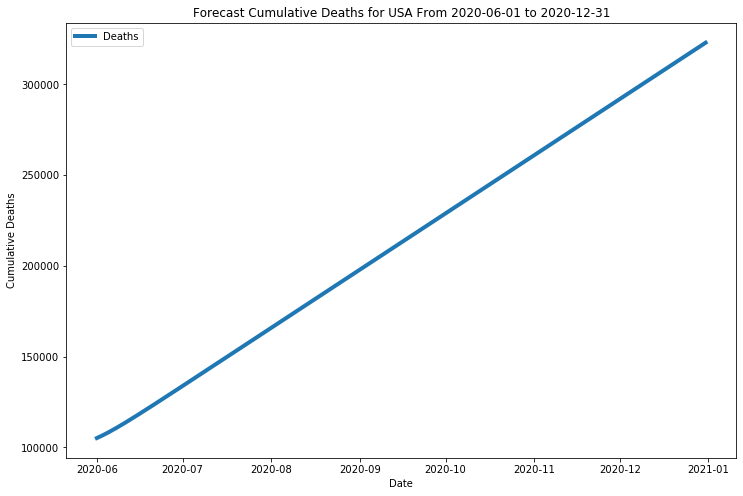

In [68]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [69]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-05-27,100418.0,1505.0
2020-05-28,101616.0,1198.0
2020-05-29,102809.0,1193.0
2020-05-30,103776.0,967.0
2020-05-31,104381.0,605.0


In [70]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()

Predicted


,Deaths,Daily_Deaths
Date_,,
2020-06-01,105098.0,717.0
2020-06-02,105812.0,714.0
2020-06-03,106570.0,758.0
2020-06-04,107366.0,796.0
2020-06-05,108194.0,828.0
